In [2]:
from config.config_1 import env
from models.DQN import DQN
from models.random import RandomAgent

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.8
batch_size = 32
buffer_size = 15_000
update_target_every = 50

epsilon_start = 0.9
decrease_epsilon_factor = 5_000
epsilon_min = 0.05

learning_rate = 5e-4

N_episodes = 200

agent = DQN(
    action_space, 
    observation_space,
    gamma, 
    batch_size, 
    buffer_size, 
    update_target_every, 
    epsilon_start, 
    decrease_epsilon_factor, 
    epsilon_min, 
    learning_rate,
    [256,256]
)

In [4]:
def eval_agent(agent, env, n_sim=5):
    """
    ** Solution **
    
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

In [5]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(env, agent, N_episodes, eval_every=10, reward_threshold=200):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for episode in range(N_episodes):
        done = False
        state, _ = env.reset()
        ep_reward = 0
        while not done:
            action = agent.get_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            loss_val = agent.update(state, action, reward, done, next_state)

            state = next_state
            losses.append(loss_val)
            
            total_time += 1
        if (episode+1) % eval_every == 0:
            rewards = eval_agent(agent, env)
            print(f"Episode {episode+1} - Reward: {np.mean(rewards)}")
            # Log other metrics as needed
            writer.add_scalar("ep_reward", np.mean(rewards), episode)
            if np.mean(rewards) >= reward_threshold:
                print(f"Task solved in {episode} episodes!")
                break
        
        # Log the loss value
        writer.add_scalar("Loss", loss_val, episode)
        
    # Close the SummaryWriter
    writer.close()
    
    return losses

In [6]:
losses = train(env, agent, N_episodes, eval_every=50)


Episode 50 - Reward: 10.9375
Episode 100 - Reward: 2.359673653626948
Episode 150 - Reward: 2.825
Episode 200 - Reward: 13.25


mean reward after training =  10.917529662241051
std reward after training =  5.147778492144512


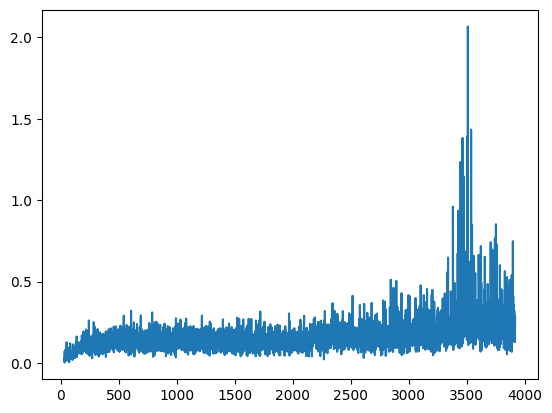

In [7]:

plt.plot(losses)

# Evaluate the final policy
rewards = eval_agent(agent, env, 50)
print("mean reward after training = ", np.mean(rewards))
print("std reward after training = ", np.std(rewards))

In [8]:
random_agent = RandomAgent(action_space)
rewards = eval_agent(random_agent, env, 20)
print("mean reward of random agent = ", np.mean(rewards))

mean reward of random agent =  1.9836902092953672


In [9]:
while True: 
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        env.render()
        time.sleep(0.1)
    time.sleep(1)
env.close()

AttributeError: 'NoneType' object has no attribute 'get_image'

In [ ]:
torch.save(agent.q_net.state_dict(), "2024-04-15_dqn-model-3.pth")

In [ ]:
agent.epsilon

0.3630103789216135

In [ ]:
import torch
torch.cuda.is_available()

False